In [3]:
import sys
sys.path.insert(0, r'../../quetzal/')
import syspy

import geopandas as gpd
import pandas as pd
ipath = r'inputs/'

In [4]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10, 10)

## Nearest neighbor

In [5]:
nodes = gpd.read_file(ipath + r'nodes.geojson')
clusters = gpd.read_file(ipath + r'clusters.geojson')

In [9]:
from syspy.syspy_utils import neighbors

SQLalchemy is not installed. No support for SQL output.


In [15]:
neighbors.nearest(nodes, clusters)

,ix_one,index_nn,ix_many,distance,rank
0,0,316,316,0.000000,0
1,1,493,493,31.045714,0
424,424,493,493,31.045714,0
2,2,77,77,21.076526,0
720,720,77,77,21.076526,0
...,...,...,...,...,...
1022,1022,308,308,23.121956,0
1027,1027,308,308,23.121956,0
1026,1026,185,185,53.094864,0
1030,1030,185,185,53.094864,0


In [20]:
nodes['nearest_id'] = neighbors.nearest(nodes, clusters).set_index('ix_one')['ix_many']

<font color='#D22328'>
# Exercice
</font>

Créer un GeoDataFrame nearest_link, contenant les colonnes:
- node_id
- cluster_id
- geometry (LineString entre un node et son plus proche voisin)

In [23]:
clusters

,cluster,geometry
0,0,POINT (434823.617 6715890.484)
1,1,POINT (432375.612 6710577.892)
2,2,POINT (430315.179 6716075.961)
3,3,POINT (435573.833 6711152.233)
4,4,POINT (429807.490 6720485.979)
...,...,...
507,507,POINT (438234.420 6712370.674)
508,508,POINT (433926.898 6713841.771)
509,509,POINT (437490.775 6710414.325)
510,510,POINT (431931.637 6715156.247)


In [25]:
merged = nodes.merge(clusters, left_on='cluster_id', right_on='cluster')

,index,stop_name,geometry_x,cluster_id,nearest_id,cluster,geometry_y
0,node_CHAMF-E,CHAMPFLEUR,POINT (436223.588 6715001.597),316,316,316,POINT (436223.588 6715001.597)
1,node_MENDES-E,MENDES FRANCE,POINT (433029.204 6714060.184),493,493,493,POINT (433005.710 6714039.889)
2,node_MENDESFR,MENDES FRANCE,POINT (432982.217 6714019.594),493,493,493,POINT (433005.710 6714039.889)
3,node_VIGNES,LES VIGNES,POINT (426628.541 6707230.624),77,77,77,POINT (426629.423 6707209.566)
4,node_VIGNES-E,LES VIGNES,POINT (426630.305 6707188.508),77,77,77,POINT (426629.423 6707209.566)
...,...,...,...,...,...,...,...
1051,node_LABRUYER,LA BRUYERE,POINT (430923.709 6714563.059),308,308,308,POINT (430943.160 6714550.558)
1052,node_LABRUY-E,LA BRUYERE,POINT (430962.610 6714538.056),308,308,308,POINT (430943.160 6714550.558)
1053,node_FRATER,FRATERNITE,POINT (432011.649 6716102.539),185,185,185,POINT (431958.554 6716102.655)
1054,node_FRATE-E,FRATERNITE,POINT (431905.459 6716102.772),185,185,185,POINT (431958.554 6716102.655)


In [33]:
from shapely.geometry import LineString
def row_to_line(row):
    # row = merged.iloc[0]
    return LineString([row['geometry_x'], row['geometry_y']])

merged['geometry'] = merged.apply(row_to_line, axis=1)

gpd.GeoDataFrame(merged).plot()

In [48]:
df = neighbors.nearest(nodes, clusters)
node_geoms = nodes['geometry'].to_dict()
cluster_geoms = clusters['geometry'].to_dict()
df['geometry'] = df.apply(
    lambda x: LineString(
        (
            node_geoms[x['ix_one']],
            cluster_geoms[x['ix_many']]
        )
    ),
    axis=1
)
gpd.GeoDataFrame(df).to_file(r'inputs/nearest_link_shp.geojson')

## Desire lines

In [62]:
zones = gpd.read_file(ipath + 'zones_neighbors.geojson').set_index('zone_id')
ods = pd.read_csv(ipath + r'ods.csv', index_col=0)

In [63]:
neighborhood = neighbors.Neighborhood(
    zones.to_crs(epsg=4236), # only works in lat lon
    ods,
    ['volume']
)

FloatProgress(value=0.0, max=8.0)

neighborhood_dataframe: 100%|██████████| 370/370 [00:02<00:00, 134.58it/s]


In [64]:
od_geoms = neighborhood.export(
    'volume',
    affected=False,
)

No projection defined --> considered as EPSG:4326
can only map affected volumes with arg : od_geometry=False


In [65]:
from shapely.geometry import LineString

od_geoms['geometry'] = od_geoms.apply(
    lambda x: LineString(
        [
            (x['longitude_origin'], x['latitude_origin']),
            (x['longitude_destination'], x['latitude_destination'])
        ]
    ), 
    1
)

od_geoms = gpd.GeoDataFrame(od_geoms)[
    ['origin', 'destination', 'volume',
    'geometry', 'label', 'color', 'width']
]
od_geoms.to_file(
    ipath + r'desire_lines/non_affected_ods.geojson', driver='GeoJSON'
)

In [66]:
desire_lines = neighborhood.export(
    'volume',
    affected=True,
)
desire_lines = gpd.GeoDataFrame(desire_lines)[
    ['origin', 'destination', 'volume', 'volume_transit',
    'geometry', 'label', 'color', 'width']
]
desire_lines.to_file(
    ipath + r'desire_lines/affected_ods.geojson', driver='GeoJSON'
)

No projection defined --> considered as EPSG:4326


# classified desire lines

In [69]:
from syspy.spatial import spatial
cluster_geoms, cluster_ids = spatial.zone_clusters(
    zones, n_clusters=3
)
zones['cluster'] = cluster_ids

<AxesSubplot:>

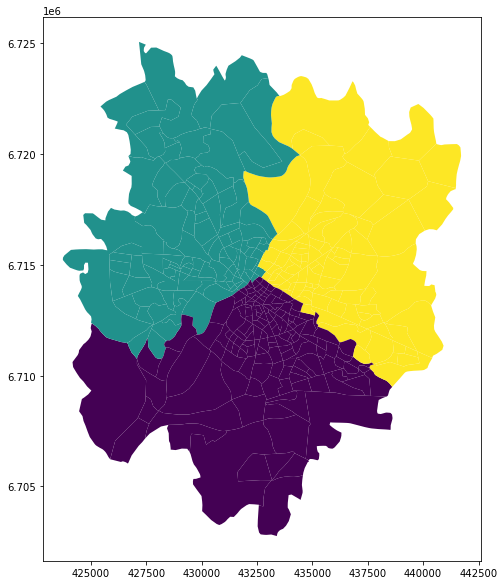

In [70]:
zones.plot('cluster')

In [71]:
neighbors.zones_classified_neighborhood(
    zones, ods, ipath + r'desire_lines/macro/', 'cluster', volume_col='volume'
)


0


FloatProgress(value=0.0, max=8.0)

neighborhood_dataframe: 100%|██████████| 370/370 [00:02<00:00, 150.06it/s]


2


FloatProgress(value=0.0, max=8.0)

neighborhood_dataframe: 100%|██████████| 370/370 [00:02<00:00, 149.98it/s]


1


FloatProgress(value=0.0, max=8.0)

neighborhood_dataframe: 100%|██████████| 370/370 [00:02<00:00, 146.24it/s]
3it [00:00,  4.83it/s]
